# Finding our best-performing salespeople and products

**Total points**: 24 points

## Introduction

**Business Context.** You work for AdventureWorks, a company that sells outdoor sporting equipment. The company has many different locations and has been recording the sales of different locations on various products. You, their new data scientist, have been tasked with the question: *What are our best products and salespeople, and how can we use this information to improve our overall performance?*

You have been given access to the relevant data files with documentation from the IT department. Your job is to extract meaningful insights from these data files to help increase sales. First, you will look at the best products and try to see how different products perform in different categories. Second, you will analyze the best salespeople to see if the commission percentage motivates them to sell more.

**Business Problem.** Your task is to *write queries in SQL to carry out the requested analysis*.

**Analytical Context.** You are given the data as an SQLite database. The company has been pretty vague about how they expect you to extract insights, but you have come up with the following plan of attack:

1. Load the database and ensure you can run basic queries against it
2. Look at how product ratings and total sales are related
3. See how products sell in different subcategories (bikes, helmets, socks, etc.)
4. Calculate which salespeople performed the best in 2014
5. See if total sales are correlated with commission percentage

Of course, this is only your initial plan. As you explore the database, your strategy will likely change.

## Overview of the data

The data for this case is contained in the [`AdventureWorks.db`](AdventureWorks.db) SQLite database. We will be focusing on the tables that belong to the Sales and Product categories. Complete documentation, with schemas, for the original data (of which you have only a subset) can be found [here](data/AdventureWorks.pdf).

**Product Tables (Pg. 34 in the documentation):**
* **Product**: one row per product that the company sells
* **ProductReview**: one row per rating and review left by customers
* **ProductModelProductDescriptionCulture**: a link between products and their longer descriptions also indicating a "culture" - which language and region the product is for
* **ProductDescription**: a longer description of each product, for a specific region
* **ProductCategory**: the broad categories that products fit into
* **ProductSubCategory**: the narrower subcategories that products fit into

**Sales Tables (Pg. 71 in the documentation):**
* **SalesPerson**: one row per salesperson, including information on their commission and performance
* **SalesOrderHeader**: one row per sale summarizing the sale
* **SalesOrderDetail**: many rows per sale, detailing each product that forms part of the sale
* **SalesTerritory**: the different territories where products are sold, including performance
* **CountryRegionCurrency**: the currency used by each region
* **CurrencyRate**: the average and closing exchange rates for each currency compared to the USD

**Tip**: Review the rest of the documentation carefully to learn more about the tables (like relevant columns in each) and the relationships between them. Note that not all columns may be available in the subset provided in this case, as they are not necessary for the following exercises. 

Let's now load the database:

In [1]:
%FETCH https://amzn-dana.workspace-lite.correlation-one.com/extended.sql_jlite_fellow/files/data/AdventureWorks.db AdventureWorks

Start downloading from URL https://amzn-dana.workspace-lite.correlation-one.com/extended.sql_jlite_fellow/files/data/AdventureWorks.db
Finished downloading 20185088 bytes from URL https://amzn-dana.workspace-lite.correlation-one.com/extended.sql_jlite_fellow/files/data/AdventureWorks.db
Writing downloaded data to file AdventureWorks
Finished writing file


In [2]:
%LOAD AdventureWorks RW

**Note**: Do not round your results (i.e., leave them with as many decimal digits as they have). Also, be sure to name your columns *exactly* as they are in the sample tables in each exercise.

## Finding our most popular products

The company would like to know which of its products is the most popular among customers. You figure that the average rating given in reviews is correlated with the number of sales of a particular product (that products with higher reviews have more sales).

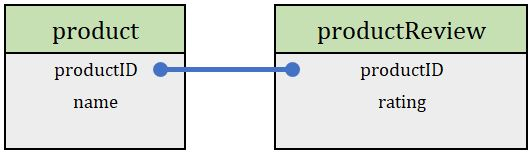### Exercise 1 (1 point)

Using the **`product`** and **`productReview`** tables, **`INNER JOIN`** them and rank the products according to their average review rating.

Below is a simplified visual of the **`ERD (Entity Relationship Diagram)`**, which outlines the table that you will be working with.  

* The **`Table Name`** is the green header.
* The **`Column Header`** is listed under their respective Table Name.
* The **`Blue Line`** is there to show the **`JOIN`** column.
* Based on this information, write a query to retrieve product review details for each product.
* For more detailed information about the Tables, refer to the [documentation](data/AdventureWorks.pdf).

![EC4 Exercise 1 - Tables](data/images/EC4_Exercise1_Visual.JPG)

<br>

**Additional Hints:**

* Each table has more columns than what is shown in the diagram. 
* To view all of the columns, use one of the two methods.  **`SELECT everything`**, or use **`Pragma`**.
* You will need to use **`GROUP BY`** to group multiple reviews together.
* **`avgrating`** is an aggregated column, it takes the average of multiple reviews.
* **`num_ratings`** is an aggregated column, it counts the number of reviews for a particular product.
* Be aware that SQL is syntax sensitive, meaning the order which you write your query matters.  Check the **`Sample Code`** section for more detail.

<br>

Here is a sample output what your answer should look like:

| productid | NAME                   | avgrating | num_ratings |
|-----------|------------------------|-----------|:-----------:|
| 709       | Mountain Bike Socks, M | 5.0       | 1           |
| …         | …                      | …         | …           |

<br>

**Sample Code:**
~~~sql
-- This will output 1 row of information from the Table with all of the columns.
SELECT *
FROM TableName
LIMIT 1

-- This will show you a list of columns within a table.
pragma table_info( 'Insert a table name in here' )

-- This is the order of SQL needs to be written in.
SELECT
FROM
JOIN
WHERE
GROUP BY
HAVING
ORDER BY
LIMIT
~~~

<br>

**Additional Learning Resources:**

* [W3 School - JOIN](https://www.w3schools.com/sql/sql_join.asp)
* [W3 School - GROUP BY](https://www.w3schools.com/sql/sql_groupby.asp)
* [W3 School - Aggregate Functions](https://www.w3schools.com/sql/sql_count_avg_sum.asp)

**Answer.**

In [54]:
SELECT product.productid AS ProductID, Name, AVG(rating) AS Avgrating, COUNT(rating) AS Num_ratings
FROM product
JOIN productreview ON product.productid = productreview.productid 
GROUP BY NAME, product.productid
ORDER BY Avgrating DESC;

ProductID,NAME,Avgrating,Num_ratings
709,"Mountain Bike Socks, M",5.0,1
798,"Road-550-W Yellow, 40",5.0,1
937,HL Mountain Pedal,3.0,2


### Exercise 2 

### Exercise 2.1 (1 point)

Much to your disappointment, there are only three products with ratings and only four reviews in total! This is nowhere near enough to perform an analysis of the correlation between **`reviews`** and **`total sales`**. Since we cannot infer the most popular products from the reviews, we will go with an alternative strategy. The database includes transactions in different **`currencies`** and **`products`** from different cultures.  Since we don't have sufficient detail within the reviews, we turn our attention to extracting this insights from **`sales`** data.  

<br>

Here is a visual of the tables and columns that you will be working with.

* There are two tables **`productModelProductDescriptionCulture`** and **`productDescription`**.
* **`JOIN`** the tables together by the column with the **`Blue Line`**.
* For this exercise, include only descriptions for which **`productModelProductDescriptionCulture.cultureID = 'en'`**.
* Get the **`productModelID`** and **`description`** for each product.  

![EC4 Exercise 2.1 - Tables](data/images/EC4_Exercise2-1_Visual.JPG)

<br>

**Additional Hints:**

* Use **`Alias`** to shorten long table names.

<br>

Your output should look like this:

<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th>productmodelid</th>      <th>description</th>    </tr>  </thead>  <tbody>    <tr>      <td>1</td>      <td>Light-weight, wind-resistant, packs to fit into a pocket.</td>    </tr>    <tr>      <td>2</td>      <td>Traditional style with a flip-up brim; one-size fits all.</td>    </tr>    <tr>      <td>3</td>      <td>Synthetic palm, flexible knuckles, breathable mesh upper. Worn by the AWC team riders.</td>    </tr>    <tr>      <td>...</td>      <td>...</td>    </tr>  </tbody></table>

<br>

**Additional Learning Resources:**

* [W3 School - Alias](https://www.w3schools.com/sql/sql_alias.asp) 

**Answer.**

In [41]:
SELECT productModelProductDescriptionCulture.productmodelid AS productModelID, productDescription.description AS description
FROM productModelProductDescriptionCulture
JOIN productDescription ON productModelProductDescriptionCulture.productDescriptionID = productDescription.productDescriptionID
WHERE productModelProductDescriptionCulture.cultureID = 'en'
limit 10;

productModelID,description
1,"Light-weight, wind-resistant, packs to fit into a pocket."
2,Traditional style with a flip-up brim; one-size fits all.
3,"Synthetic palm, flexible knuckles, breathable mesh upper. Worn by the AWC team riders."
4,"Full padding, improved finger flex, durable palm, adjustable closure."
5,Each frame is hand-crafted in our Bothell facility to the optimum diameter and wall-thickness required of a premium mountain frame. The heat-treated welded aluminum frame has a larger diameter tube that absorbs the bumps.
6,Our lightest and best quality aluminum frame made from the newest alloy; it is welded and heat-treated for strength. Our innovative design results in maximum comfort and performance.
7,The HL aluminum frame is custom-shaped for both good looks and strength; it will withstand the most rigorous challenges of daily riding. Men's version.
8,"Our best value utilizing the same, ground-breaking frame technology as the ML aluminum frame."
9,"The LL Frame provides a safe comfortable ride, while offering superior bump absorption in a value-priced aluminum frame."
10,Lightweight butted aluminum frame provides a more upright riding position for a trip around town. Our ground-breaking design provides optimum comfort.


#### Exercise 2.2 (2 points)

Now that we got the **`productModelID`** and its **`description`**.  We can use the result in Exercise 2.1 to further expand our query to find out its **`name`**, and the **`quantity`** it sold. To do this, we will use **`CTE (Common Table Expression)`** to turn our Exercise 2.1 solution into a temporary table.

<br>

Here is a visual of the tables and columns that you will be working with.

* Using the answer in Exercise 2.1, wrap your solution into a **`CTE view`** called **`english_description`**, the **`Blue Header`** shows that the table is only there temporary.
* With CTE View created, you can **`JOIN`** the **`CTE View`** along with other tables.
* Get the **`productModelID`**, **`description`**, **`name`**, and **`total number of sales`** for each product and display the top-10 selling products.
* You can infer how often products have been sold by looking at the **`salesOrderDetail`** table (each row might indicate more than one sale, so take note of **`OrderQty`**).

![EC4 - Exercise 2.2 - Tables](data/images/EC4_Exercise2-2_Visual.JPG)

<br>

**Additional Hints:** 

* Make the query you wrote in Exercise 2.1 a temporary view with the **`WITH ... AS`** syntax. It will give you the English descriptions of the products as a starting point. 
* Then **`JOIN`** the temporary table with other relevant tables.
* This exercise require multiple **`JOIN`** to link several tables together.
* You will need to use combination of **`ORDER BY`** and **`LIMIT`** to sort the table to get TOP 10 products.
* **`total_orders`** is an aggregated column that sums up the quantity of units ordered.

<br>

Your output should look like this:

<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th>productmodelid</th>      <th>description</th>      <th>NAME</th>      <th>total_orders</th>    </tr>  </thead>  <tbody>    <tr>      <td>2</td>      <td>Traditional style with a flip-up brim; one-size fits all.</td>      <td>AWC Logo Cap</td>      <td>8311</td>    </tr>    <tr>      <td>111</td>      <td>AWC logo water bottle - holds 30 oz; leak-proof.</td>      <td>Water Bottle - 30 oz.</td>      <td>6815</td>    </tr>    <tr>      <td>33</td>      <td>Universal fit, well-vented, lightweight , snap-on visor.</td>      <td>Sport-100 Helmet, Blue</td>      <td>6743</td>    </tr>    <tr>      <td>...</td>      <td>...</td>      <td>...</td>      <td>...</td>    </tr>  </tbody></table>

<br>

**Additional Learning Resources:**

* [What Is a Common Table Expression (CTE) in SQL?](https://learnsql.com/blog/what-is-common-table-expression/)
* [How to use CTE using WITH...AS](https://www.youtube.com/watch?v=_SanZ41uTlw)

**Answer.**

In [40]:
WITH english_description AS
(
    SELECT 
        productModelProductDescriptionCulture.productmodelid AS productModelID, 
        productDescription.description AS description
    
    FROM productModelProductDescriptionCulture
    
    JOIN productDescription 
        ON productModelProductDescriptionCulture.productDescriptionID = productDescription.productDescriptionID
    WHERE productModelProductDescriptionCulture.cultureID = 'en'
)

SELECT english_description.productmodelid As productmodelid, english_description.description AS description, product.name As name, SUM(salesOrderDetail.OrderQty) As total_orders
FROM english_description
JOIN product ON english_description.productmodelid = product.productmodelid
JOIN salesOrderDetail ON product.productID = salesOrderDetail.productID
GROUP BY english_description.productmodelid, product.productID
ORDER by total_orders DESC
limit 10;

productmodelid,description,name,total_orders
2,Traditional style with a flip-up brim; one-size fits all.,AWC Logo Cap,8311
111,AWC logo water bottle - holds 30 oz; leak-proof.,Water Bottle - 30 oz.,6815
33,"Universal fit, well-vented, lightweight , snap-on visor.","Sport-100 Helmet, Blue",6743
11,Unisex long-sleeve AWC logo microfiber cycling jersey,"Long-Sleeve Logo Jersey, L",6592
33,"Universal fit, well-vented, lightweight , snap-on visor.","Sport-100 Helmet, Black",6532
33,"Universal fit, well-vented, lightweight , snap-on visor.","Sport-100 Helmet, Red",6266
1,"Light-weight, wind-resistant, packs to fit into a pocket.","Classic Vest, S",4247
114,"Includes 8 different size patches, glue and sandpaper.",Patch Kit/8 Patches,3865
32,"Short sleeve classic breathable jersey with superior moisture control, front zipper, and 3 back pockets.","Short-Sleeve Classic Jersey, XL",3864
11,Unisex long-sleeve AWC logo microfiber cycling jersey,"Long-Sleeve Logo Jersey, M",3636


### Exercise 3

To get a better sense of the sales, let's look at the correlation between the **`quantity sold`** and the price for each **`subcategory`**.  We will break this process into three steps.

1. Find out the **`quantity sold`** by their **`productID`**.
2. Next we will query the **`listing price`** by their **`productID`** and their respective **`category`** and **`subcategory`**.
3. Finally, we will **`JOIN`** both results together so we will know how many were sold by their **`category`** and **`subcategory`**

#### Exercise 3.1 (1 Point)
First we want to start by writing a query that shows how many items were ordered in total for every product in the database. Do *not* filter by culture.

Here is a visual of the tables and columns that you will be working with.

![EC4 Exercise 3.1 - Tables](data/images/EC4_Exercise3-1_Visual.JPG)

<br>

**Additional Hints:** 
* Use the **`salesOrderDetail`** table.
* **`quantity`** is an aggregated column that sums up the quantity of unit sold and **`GROUP BY`** the product id.

<br>

Your output should look like this:

| productid | quantity |
|-----------|----------|
| 707       | 6266     |
| 708       | 6532     |
| 709       | 1107     |
| 710       | 90       |
| 711       | 6743     |
| 712       | 8311     |
| 713       | 429      |
| 714       | 3636     |
| …         | …        |


**Answer.**

In [31]:
SELECT productid, SUM(orderqty) AS quantity
From salesOrderDetail
GROUP BY productid
limit 10;

productid,quantity
707,6266
708,6532
709,1107
710,90
711,6743
712,8311
713,429
714,3636
715,6592
716,2980


#### 3.2 (1 point)

Awesome! Next, we need to know the **`list price`** for each product alongside its **`category`** and **`subcategory`**.

Here is a visual of the tables and columns that you will be working with.

![EC4 Exercise 3.2 - Tables](data/images/EC4_Exercise3-2_Visual.JPG)

<br>

**Additional Hints:** 
* You will find the product categories in the **`productCategory`** table, and the subcategories in the **`productSubcategory`** table.
* Use multiple JOIN to connect **`product`**, **`productCategory`**, and **`productSubcategory`** tables together.

<br>

Your output should look like this:

| productid | category    | subcategory | listprice |
|-----------|-------------|-------------|-----------|
| 680       | Components  | Road Frames | 1431.5    |
| 706       | Components  | Road Frames | 1431.5    |
| 707       | Accessories | Helmets     | 34.99     |
| 708       | Accessories | Helmets     | 34.99     |
| 709       | Clothing    | Socks       | 9.5       |
| 710       | Clothing    | Socks       | 9.5       |
| 711       | Accessories | Helmets     | 34.99     |
| 712       | Clothing    | Caps        | 8.99      |
| 713       | Clothing    | Jerseys     | 49.99     |
| 714       | Clothing    | Jerseys     | 49.99     |
| 715       | Clothing    | Jerseys     | 49.99     |
| 716       | Clothing    | Jerseys     | 49.99     |
| 717       | Components  | Road Frames | 1431.5    |
| 718       | Components  | Road Frames | 1431.5    |
| 719       | Components  | Road Frames | 1431.5    |
| …         | …           | …           | …         |


**Answer.**

In [42]:
SELECT product.productid AS productid, productCategory.name AS category, productSubcategory.name AS subcategory, product.listprice AS listprice
FROM product
JOIN productSubcategory ON product.productSubcategoryID = productSubcategory.productSubcategoryID
JOIN productCategory ON productSubcategory.productcategoryID = productCategory.productCategoryID
limit 10;


productid,category,subcategory,listprice
680,Components,Road Frames,1431.5
706,Components,Road Frames,1431.5
707,Accessories,Helmets,34.99
708,Accessories,Helmets,34.99
709,Clothing,Socks,9.5
710,Clothing,Socks,9.5
711,Accessories,Helmets,34.99
712,Clothing,Caps,8.99
713,Clothing,Jerseys,49.99
714,Clothing,Jerseys,49.99


#### Exercise 3.3 (3 points)

Now that we have the productID and its quantity sold from Exercise 3.1, as well as the category, subcategory and list price from Exericse 3.2.  We can now merge the two solutions together to obtain a table showing the **`average list price`** and the **`total quantity of products sold`** for each subcategory. 

<br>

Here is a visual of the tables and columns that you will be working with.

* We need to put our answers from **`Exercise 3.1`** and **`Exercise 3.2`** into their respective CTE.
* Then use **`JOIN`** to join the 2 CTE tables together.

![EC4 Exercise 3.3 - Tables](data/images/EC4_Exercise3-3_Visual.JPG)

<br>

**Additional Hints:**
* To have two **`WITH ... AS`** statements in the same query, you separate the subqueries with a comma and don't write **`WITH`** again. Like the sample code below.
* If you used any **`LIMIT CLAUSES`** in previous Exercise, remove them.
* **`average_price_in_subcategory`** is an aggregated column calculated from the CTE.
* **`total_items_sold_in_subcategory`** is an aggregated column calculated from the CTE.

<br>

Your output should look like this:

| category    | subcategory       | average_price_in_subcategory | total_items_sold_in_subcategory |
|-------------|-------------------|------------------------------|---------------------------------|
| Accessories | Bike Racks        | 120.0                        | 3166                            |
| Accessories | Bike Stands       | 159.0                        | 249                             |
| Accessories | Bottles and Cages | 7.989999999999999            | 10552                           |
| Accessories | Cleaners          | 7.95                         | 3319                            |
| Accessories | Fenders           | 21.98                        | 2121                            |
| Accessories | Helmets           | 34.99                        | 19541                           |
| Accessories | Hydration Packs   | 54.99                        | 2761                            |
| Accessories | Locks             | 25.0                         | 1087                            |
| Accessories | Pumps             | 19.99                        | 1130                            |
| Accessories | Tires and Tubes   | 19.482727272727274           | 18006                           |
| Bikes       | Mountain Bikes    | 1683.3649999999982           | 28321                           |
| Bikes       | Road Bikes        | 1597.45                      | 47196                           |
| Bikes       | Touring Bikes     | 1425.2481818181814           | 14751                           |
| Clothing    | Bib-Shorts        | 89.99                        | 3125                            |
| …           | …                 | …                            | …                               |

<br>

**Sample Code:**
~~~sql
WITH first_query_alias AS
(
    SELECT ...
),
second_query_alias AS -- Notice we didn't include a second WITH here
(
    SELECT...
)
SELECT ...
~~~

**Answer.**

In [67]:
WITH product_quantities AS
(
    SELECT productid, SUM(orderqty) AS quantity
    From salesOrderDetail
    GROUP BY productid
),
product_prices AS
(
    SELECT product.productid AS productid, productCategory.name AS category, productSubcategory.name AS subcategory, product.listprice AS listprice
    FROM product
    JOIN productSubcategory ON product.productSubcategoryID = productSubcategory.productSubcategoryID
    JOIN productCategory ON productSubcategory.productcategoryID = productCategory.productCategoryID
)
SELECT category, subcategory, AVG(listprice) AS average_price_in_subcategory, SUM(quantity) AS total_items_sold_in_subcategory
FROM product_prices
JOIN product_quantities ON product_quantities.productID = product_prices.productID
GROUP BY subcategory
ORDER BY category
LIMIT 10;

category,subcategory,average_price_in_subcategory,total_items_sold_in_subcategory
Accessories,Bike Racks,120.0,3166
Accessories,Bike Stands,159.0,249
Accessories,Bottles and Cages,7.99,10552
Accessories,Cleaners,7.95,3319
Accessories,Fenders,21.98,2121
Accessories,Helmets,34.99,19541
Accessories,Hydration Packs,54.99,2761
Accessories,Locks,25.0,1087
Accessories,Pumps,19.99,1130
Accessories,Tires and Tubes,19.4827272727273,18006


Turns out there is a positive correlation between average price and items sold ($\rho=0.68$). This is somewhat unexpected since common sense tells us that the more expensive an item is, the lower the demand for it. It is possible that we are witnessing an instance of Simpson's Paradox here. To verify if that is indeed the case, we could instead compute the correlation coefficient for each subcategory, possibly evidencing a negative correlation coefficient in some subcategories. We will not do that right now however, since it would make us deviate too much from our business problem. (You can use Excel for tasks like this.)

## Finding our top salespeople

As mentioned earlier, we want to find our best salespeople and see whether or not we can incentivize them in an appropriate manner. Namely, we want to determine if the commission percentage we give them motivates them to make more and bigger sales.

### Exercise 4 (1 point)

Let's start by finding our top five performing salespeople by using the **`salesytd`** (Sales, year-to-date) column.

Here is a visual of the tables and columns that you will be working with.

![EC4 Exercise 4 - Tables](data/images/EC4_Exercise4_Visual.JPG)

<br>

**Additional Hints:**
* We only need to know the **`businessEntityID`** for each salesperson as this uniquely identifies each salesperson. 
* Your query should, therefore, only have two columns: **`businessEntityID`** and **`salesytd`**.
* Do not round the numbers.

<br>

Your output should look like this:

<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th>businessentityid</th>      <th>salesytd</th>    </tr>  </thead>  <tbody>    <tr>      <td>276</td>      <td>4251368.5497</td>    </tr>    <tr>      <td>289</td>      <td>4116871.2277</td>    </tr>    <tr>      <td>275</td>      <td>3763178.1787</td>    </tr>    <tr>      <td>...</td>      <td>...</td>    </tr>  </tbody></table>


**Answer.**

In [51]:
SELECT businessEntityID, SUM(salesytd)
FROM salesPerson
GROUP BY businessEntityID
ORDER BY salesytd DESC
LIMIT 10;


businessentityid,SUM(salesytd)
276,4251368.5497
289,4116871.2277
275,3763178.1787
277,3189418.3662
290,3121616.3202
282,2604540.7172
281,2458535.6169
279,2315185.611
288,1827066.7118
284,1576562.1966


### Exercise 5 (2 points)

The sales numbers from the previous query are hard-coded into the **`salesPerson`** table instead of dynamically calculated from each sales record. Currently, we don't know how this number is updated or much about it at all, so it's good to remain skeptical.

<br>

Here is a visual of the tables and columns that you will be working with.

* Using the **`salesOrderHeader`** table, find the top 5 salespeople who made the most sales *in the most recent year available* (2014) (there is a column called **`subtotal`** - use that.) 
* Sales that do not have an associated salesperson should be excluded from your calculations and final output.
* All orders that were made within the 2014 calendar year should be included.

![EC4 Exercise 5 - Tables](data/images/EC4_Exercise5_Visual.JPG)

<br>

**Additional Hints:** 
* Use **`WHERE CLAUSE`** to filter the dates.
* Put into consideration that some records don't have dates, filter it using **`IS NOT NULL`** keywords, and use **`<> comparison operator`**.
* Do not worry about rounding the numbers.

You can use the syntax `WHERE column >= '1970-01-01'` to generate an arbitrary date in SQLite and compare this to specific dates in the tables (in this example, dates equal to or later than Jan 1, 1970). Additionally, when you want to make sure that columns with empty or null values are excluded from a query in SQLite, you have to add a line like this one to your `WHERE` statement: `my_column IS NOT NULL AND my_column <> ""`. The `<>` operator is the opposite of `=`; that is, it checks that two values are different from each other.

<br>

Your output should look like this:

<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th>salespersonid</th>      <th>totalsales</th>    </tr>  </thead>  <tbody>    <tr>      <td>289</td>      <td>1382996.5839000002</td>    </tr>    <tr>      <td>276</td>      <td>1271088.5216</td>    </tr>    <tr>      <td>...</td>      <td>...</td>    </tr>  </tbody></table>

<br>

**Additional Learning Resources:**
* [W3 - Working with Dates](https://www.w3schools.com/sql/sql_dates.asp)
* [W3 - Working with NULLS](https://www.w3schools.com/sql/sql_null_values.asp)
* [W3 - Using AND, OR, NOT](https://www.w3schools.com/sql/sql_and_or.asp)

**Answer.**

In [85]:
SELECT salespersonid, SUM(subtotal) AS totalsales
FROM salesOrderHeader
WHERE orderDate >= '2014-01-01' AND salespersonid IS NOT NULL AND salespersonid <> ""
GROUP BY salespersonid
ORDER BY totalsales DESC
limit 5;

salespersonid,totalsales
289,1382996.5839
276,1271088.5216
275,1057247.3786
282,1044810.8277
277,1040093.4071


You should see right away that there are discrepancies between the two sales totals. This makes sense because we used filters in one table and not the other. Nonetheless, for the remainder of this case, use this dynamically-calculated total as the authoritative answer.

### Exercise 6

Since there are discrepancies between Salesperson table and SalesOrderHeader table, let's double check this by investigating our sales record by manually adding all of the sales amount together.
<br>

Looking at the documentation, you will see that **`subtotal`** in the **`salesOrderHeader`** table is calculated from other tables in the database. To validate this figure (instead of trusting it blindly), it might be a good idea to calculate the **`subtotal`** manually. Using the **`salesOrderDetail`** and **`salesOrderHeader`** tables, let's calculate the sales for each salesperson for **the year 2014** and display the results for the top 5 salespeople.

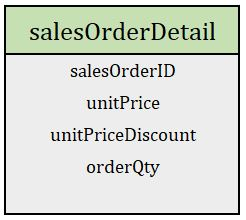#### 6.1 (1 point)

Write a query that shows the total amount of money paid by their **`salesOrderID`** (find this column in the **`salesOrderDetail`** table).

Note: It is good practice to always use a limit statement (i.e., LIMIT 10) when you do not know how large the output might be. Otherwise, the size of some of these tables may crash your browser and you will need to reload it and rewrite your queries. 

<br>

Here is a visual of the tables and columns that you will be working with.



![EC4 Exercise 6.1 - Tables](data/images/EC4_Exercise6-1_Visual.JPG)

<br>

**Additional Hints**
* The **`ordertotal`** column in the output sample is an aggregated column
* Remember to subtract **`unitPriceDiscount`** from each item's price (**`unitPriceDiscount`** is a percentage).
* You can check out [this link](https://www.geeksforgeeks.org/sql-arithmetic-operators/) to get a refresher on SQL arithmetic
* Do not worry about rounding the numbers

<br>

Your output should look like this:

| salesorderid | ordertotal         |
|--------------|--------------------|
| 43659        | 20565.6206         |
| 43660        | 1294.2529          |
| 43661        | 32726.4786         |
| 43662        | 28832.5289         |
| 43663        | 419.4589           |
| 43664        | 24432.608799999995 |
| 43665        | 14352.7713         |
| 43666        | 5056.4896          |
| 43667        | 6107.081999999999  |
| 43668        | 35944.156200000005 |
| 43669        | 714.7043           |
| …            | …                  |

<br>

**Additional Learning Resources**
* [How to Calculate Discount](https://www.omnicalculator.com/finance/percentage-discount#:~:text=To%20determine%20the%20discount%20percentage,price%20from%20the%20original%20price.)

**Answer.**

In [86]:
SELECT salesorderid, SUM((1- unitPriceDiscount)*unitprice*orderQty) AS ordertotal
FROM salesOrderDetail
GROUP BY salesorderid
LIMIT 10;

salesorderid,ordertotal
43659,20565.6206
43660,1294.2529
43661,32726.4786
43662,28832.5289
43663,419.4589
43664,24432.6088
43665,14352.7713
43666,5056.4896
43667,6107.082
43668,35944.1562


#### 6.2 (2 points)

Using the previous query as a subquery (CTE), find the sales for each salesperson for the year 2014 and display results for the top 5 salespeople. <br>
Remember to exclude sales that are not associated with a salesperson.

<br>

Here is a visual of the tables and columns that you will be working with.

* The CTE on the left is created from **`Exercise 6.1`**.
* The CTE on the right is modified from **`Exercise 5`**, you will need to add the **`salesOrderID`**.

![EC4 Exercise 6.2 - Tables](data/images/EC4_Exercise6-2_Visual.JPG)

<br>

**Additional Hints:**
* You can get the **`salesOrderID`** and **`salesPersonID`** pairs from the **`salesOrderHeader`** table.
* It is recommended to use additional CTE to help simplify your query.
* Use **`Exercise 6.1`** solution as CTE.
* Modify **`Exercise 5 `** and use it as CTE.

<br>

Your output should look like this:
<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th>salespersonid</th>      <th>ordertotalsum</th>    </tr>  </thead>  <tbody>    <tr>      <td>289</td>      <td>1382996.5839100003</td>    </tr>    <tr>      <td>276</td>      <td>1271088.5214610002</td>    </tr>    <tr>      <td>...</td>      <td>...</td>    </tr>  </tbody></table>


**Answer.**

In [22]:
WITH orders AS
(
    SELECT salesorderid, SUM((1- unitPriceDiscount)*unitprice*orderQty) AS ordertotal
    FROM salesOrderDetail
    GROUP BY salesorderid
),
salesPersonAndOrders AS
(
    SELECT salespersonid, salesorderid
    FROM salesOrderHeader
    WHERE orderDate >= '2014-01-01' AND salespersonid IS NOT NULL AND salespersonid <> ""
)
SELECT salesPersonAndOrders.salespersonID AS salespersonID, SUM(orders.ordertotal) AS odertotalsum
FROM salesPersonAndOrders
JOIN orders ON orders.salesorderID = salesPersonAndOrders.salesorderID
GROUP BY salespersonID
ORDER BY odertotalsum DESC
LIMIT 5;

salespersonID,odertotalsum
289,1382996.58391
276,1271088.521461
275,1057247.378572
282,1044810.827687
277,1040093.406901


The results are the same as Exercise 5. We still prefer this query though because it is generated from granular data instead of relying on hard-coded figures.

### Exercise 7 (3 points)

Next, let's now see whether there is a positive relationship between the **`total sales of the salespeople`** and their **`commission percentages`**. 

<br>

Here is a visual of the tables and columns that you will be working with.

* Using your previous query from **`Exercise 6.2`**, use it as CTE.
* Join the new CTE query (remove the **`LIMIT`** clause) with the **`salesPerson`** table

![EC4 Exercise 7 - Tables](data/images/EC4_Exercise7_Visual.JPG)

<br>

**Additional Hints:**
* Remember that the **`businessEntityID`** column from the **`salesPerson`** is compatible with the **`salesPersonID`** column in the query of exercise 6 (they both represent the salesperson ID).
* Use **`Nested CTE`** by encasing the entire query in Exercise 6.2 into its own CTE.
* **`JOIN`** the new **`Nested CTE`** with **`salesPerson`** table.
* Once you get your SQL output, paste the results into an Excel table and use the [`=CORREL()`](https://support.microsoft.com/en-au/office/correl-function-995dcef7-0c0a-4bed-a3fb-239d7b68ca92) formula to calculate the correlation coefficient. If it is positive, the relationship is positive. If it is negative, the relationship is negative. You can view this visually by creating a scatterplot.

<br>

You should get a table like this one:

| salespersonid | ordertotalsum      | commissionpct |
|---------------|--------------------|---------------|
| 274           | 178584.36250800002 | 0.0           |
| 275           | 1057247.378572     | 0.012         |
| 276           | 1271088.5214610002 | 0.015         |
| 277           | 1040093.406901     | 0.015         |
| …             | …                  | …             |

**Answer.**

In [35]:
With SalesPersonTotalSales AS
--following Code from 6.2
(
    WITH orders AS
(
    SELECT salesorderid, SUM((1- unitPriceDiscount) * unitprice * orderQty) AS ordertotal
    FROM salesOrderDetail
    GROUP BY salesorderid
),
salesPersonAndOrders AS
(
    SELECT salespersonid, salesorderid, SUM(subtotal) AS totalsales
    FROM salesOrderHeader
    WHERE orderDate >= '2014-01-01' AND salespersonid IS NOT NULL AND salespersonid <> ""
    GROUP BY salespersonid
)
SELECT salesPersonAndOrders.salespersonID AS salespersonID, SUM(orders.ordertotal) AS odertotalsum
FROM orders
LEFT JOIN salesPersonAndOrders ON orders.salesorderID = salesPersonAndOrders.salesorderID
GROUP BY salespersonID
ORDER BY odertotalsum DESC
)
--New Code
SELECT salespersonid, odertotalsum, commissionpct
FROM SalesPersonTotalSales 
JOIN salesPerson ON SalesPersonTotalSales.salesPersonID = salesPerson.businessEntityID
GROUP BY salesPersonID;


salespersonID,odertotalsum,commissionpct
274,1376.994,0.0
275,23388.900552,0.012
276,22021.782,0.015
277,11710.422,0.015
278,4634.91,0.01
279,4480.614,0.01
280,52587.138,0.01
281,32798.562,0.01
282,76.2,0.015
283,13573.704,0.012


We externally calculated the correlation coefficient between `ordertotalsum` and `commissionpct`, which turned out to be $\rho=0.73$. This suggests that the salespeople who earn a high commission are also those who close the bigger deals.

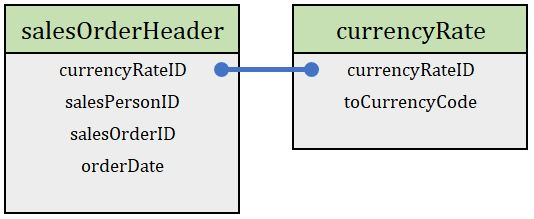## Exercise 8 

Remember how we mentioned that products were sold in many regions? This is why you had to work with the `culture` value before getting the English language descriptions. The problem is you are now told the sales are recorded in *local* currency, so your previous analyses are flawed. Technically, you must convert all amounts to USD if you wish to compare the different salespeople fairly! Instead, let's group the salespeople orders by the currency used for each order (you will have to consider `tocurrencyrate` for this task in the `CurrencyRate` table). 

#### 8.1 (1 point)

Let's explore the currencies in different sales. But first, here are some things to understand about the currency columns:
* The **`FromCurrencyCode`** is all USD, so focus on **`toCurrencyRate`**
* If the sale was paid in USD, the **`currencyRateID`** was left blank (since there was no need to make a conversion)

Create a table with the **`salesPersonID`**, **`salesOrderID`**, **`CurrencyRateID`** and **`toCurrencyCode`** to see the connection. Remember to exclude sales that are not associated with a salesperson and only consider sales in 2014. Order by the salesperson ID and show only 10 rows. 

Here is a visual of the tables and columns that you will be working with. <br>

![EC4 Exercise 8.1 - Tables](data/images/EC4_Exercise8-1_Visual.JPG)+

<br>

**Additional Hints**
* Since **`USD`** would not show up in the **`CurrencyRate`** table, you will have to do a **`LEFT JOIN`** to avoid losing information. 
* Be sure that you understand how the content of the **`CurrencyRate`** table is read and what each column means.
* Use additional cells to experiment if needed.
* The **`None`** in the above example takes the place of **`NULL`** values, which contextually means that the sale was in USD. 

<br>

Your table should look like this:

| salespersonid | salesorderid | currencyrateid | tocurrencycode |
|---------------|--------------|----------------|----------------|
| 274           | 65294        | None           | None           |
| 274           | 65298        | None           | None           |
| 274           | 67277        | None           | None           |
| 274           | 67286        | 11427          | CAD            |
| 274           | 69528        | None           | None           |
| …             | …            | …              | …              |




**Answer.**

In [9]:
SELECT salesOrderHeader.salespersonid AS salespersonid, 
salesOrderHeader.salesorderid AS salesorderid,
CurrencyRate.currencyrateid AS currencyrateid, 
CurrencyRate.tocurrencycode AS tocurrencycode
FROM salesOrderHeader
LEFT JOIN CurrencyRate ON salesOrderHeader.currencyrateid = CurrencyRate.currencyrateid
WHERE salesOrderHeader.orderdate >= '2014-01-01' AND salesOrderHeader.salespersonID IS NOT NULL
ORDER BY salespersonid
LIMIT 10;


salespersonid,salesorderid,currencyrateid,tocurrencycode
274,65294,,
274,65298,,
274,67277,,
274,67286,11427,CAD
274,69528,,
274,69545,,
274,71779,,
274,71919,,
275,65205,,
275,65215,,


As expected, we can see that different salespeople have sales in different currencies. 

**Note**: The `None` in the above example takes the place of `NULL` values, which contextually means that the sale was in USD. 

#### 8.2 (2 points)

Looking good!  We can now see which sales order are from a different currency, but there is a big issue!<br>
The **`None`** in the above query can be confusing to someone who doesn't understand the database. In this case, it's best to replace them with useful information. 

Redo the previous exercise with the following changes:
* Leave out the **`currencyRateID`** column 
* Replace **`None`** with 'USD' in the **`toCurrencyCode`** column
* One way of completing this task is to use the **`CASE`** expression, which can be incorporated as outlined in the **`Sample Code`** below. <br>

The expected output should look like this, where **`None`** has been replaced by **`USD`**, while other values remaind as is...

| salespersonid | salesorderid | tocurrencycode |
|---------------|--------------|----------------|
| 274           | 65294        | USD            |
| 274           | 65298        | USD            |
| 274           | 67277        | USD            |
| 274           | 67286        | CAD            |
| 274           | 69528        | USD            |
| …             | …            | …              |

<br>

**Additional Learning Resource**
* [W3 - CASE Expression](https://www.w3schools.com/sql/sql_case.asp)

<br>

**Sample Code**
~~~sql
SELECT column1, column2, 
CASE
    WHEN condition1 THEN result1
    ELSE result2
END AS column3
FROM TableName
~~~

**Answer.**

In [4]:
SELECT salesOrderHeader.salespersonid AS salespersonid, 
salesOrderHeader.salesorderid AS salesorderid,
CASE
    WHEN CurrencyRate.toCurrencyCode IS NULL
    THEN 'USD'
    ELSE CurrencyRate.toCurrencyCode END AS tocurrencycode
    
FROM salesOrderHeader
LEFT JOIN CurrencyRate ON salesOrderHeader.currencyrateid = CurrencyRate.currencyrateid
WHERE salesOrderHeader.orderdate >= '2014-01-01' AND salesOrderHeader.salespersonID IS NOT NULL
ORDER BY salespersonid
LIMIT 10;

salespersonid,salesorderid,tocurrencycode
274,65294,USD
274,65298,USD
274,67277,USD
274,67286,CAD
274,69528,USD
274,69545,USD
274,71779,USD
274,71919,USD
275,65205,USD
275,65215,USD


### Exercise 9 (3 points)

Much better! Now that we have the currency codes associated with each salesperson ID, redo Exercise 7, adding in the **`toCurrencyCode`**. Order the results by currency (ascending) and total sales (descending) to make it easier to see who the best salespeople are for each currency.

Here is a visual of the tables and columns that you will be working with.
 
* The ERD comes from Exercise 7 with slight modification
* **`salesPersonAndOrder`** has been modified to include **`toCurrencyCode`**
* Remember to integrate the **`CASE expression`** to get USD values in, refer to Exercise 8.2
* The resulting CTE **`salesPersonTotalSales`** is to include **`toCurrencyCode`**


![EC4 Exercise 9 - Tables](data/images/EC4_Exercise9_Visual.JPG)

<br>

This is what the expect output will look like...

| salespersonid | tocurrencycode | ordertotalsum      | commissionpct |
|---------------|----------------|--------------------|---------------|
| 286           | AUD            | 585755.800528      | 0.018         |
| 285           | AUD            | 21267.336          | 0.0           |
| 289           | CAD            | 1382996.5839100003 | 0.02          |
| …             | …              | …                  |               |

**Answer.**

In [49]:
With SalesPersonTotalSales AS
(
    WITH orders AS
(
    SELECT salesorderid, SUM((1- unitPriceDiscount) * unitprice * orderQty) AS ordertotal
    FROM salesOrderDetail
    GROUP BY salesorderid
),
salesPersonAndOrders AS
(
    SELECT salespersonid, salesorderid,
    CASE 
    WHEN CurrencyRate.toCurrencyCode IS NULL THEN 'USD'
    ELSE CurrencyRate.toCurrencyCode END AS toCurrencyCode
    FROM salesOrderHeader
    JOIN CurrencyRate ON salesOrderHeader.currencyrateid = CurrencyRate.currencyrateid
    WHERE orderDate >= '2014-01-01' AND salespersonid IS NOT NULL AND salespersonid <> ""
        
)
SELECT salesPersonAndOrders.salespersonID AS salespersonID, SUM(orders.ordertotal) AS odertotalsum, 
    salesPersonAndOrders.toCurrencyCode AS toCurrencyCode
FROM orders
JOIN salesPersonAndOrders ON orders.salesorderID = salesPersonAndOrders.salesorderID
GROUP BY salespersonID
ORDER BY odertotalsum DESC
)
SELECT salespersonid, toCurrencyCode , odertotalsum, commissionpct
FROM SalesPersonTotalSales 
JOIN salesPerson ON SalesPersonTotalSales.salesPersonID = salesPerson.businessEntityID
--GROUP BY salesPersonID
ORDER BY toCurrencyCode ASC, odertotalsum DESC;


salespersonID,toCurrencyCode,odertotalsum,commissionpct
286,AUD,585755.800528,0.018
285,AUD,21267.336,0.0
289,CAD,1382996.58391,0.02
278,CAD,435948.955166,0.01
274,CAD,11802.564,0.0
288,EUR,581358.389381,0.018
290,EUR,88188.927072,0.016
287,EUR,56637.7478,0.0
282,GBP,1044810.827687,0.015


## CONGRATULATIONS!!!
You did it!  You have completed ALL Extended Cases!  I hope that you all feel more confident in your abilities to use the technologes taught in this program! <br>

To keep your skillset sharp, we highly encourage you to further explore and utilize what you've learned by building your own portfolio.  Use public datasets or collect your own data through webscraping and continue building your style of analytics.

It has been an amazing journey with you all and we wish you all the best! 

Pat yourself on the back, because you did it!

## Attribution

"AdventureWorks database", Nov 7, 2017, Microsoft Corporation, [MIT License](https://docs.microsoft.com/en-us/sql/samples/sql-samples-where-are?view=sql-server-ver15), https://github.com/microsoft/sql-server-samples/tree/master/samples/databases/adventure-works